In [31]:
!pip install deep-translator scikit-learn
!pip install pandas tiktoken huggingface_hub streamlit nltk matplotlib seaborn tensorflow


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


*1. Text Translation*
This cell uses the deep_translator library to translate text from English to Russian. The translate_text function performs the translation of the provided text into the target language, and the result is printed to verify its correctness.

In [16]:
from deep_translator import GoogleTranslator

def translate_text(text, target_language='ru'):
    translated_text = GoogleTranslator(source='auto', target=target_language).translate(text)
    return translated_text

translated_text = translate_text("Hello, how are you?", 'ru')
print(translated_text)

Привет, как дела?


*2. Inspecting JSONL Files*
The inspect_jsonl function reads the first few lines from a JSONL file and loads them into a list of dictionaries. This step helps in reviewing the structure and content of the data before further processing.

In [17]:
import json

def inspect_jsonl(file_path, num_lines=1):
    data = []
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if i < num_lines:
                data.append(json.loads(line))
            else:
                break
    return data

sample_data = inspect_jsonl('data/train.jsonl', num_lines=1)
print(json.dumps(sample_data, indent=2, ensure_ascii=False))

[
  {
    "phase": 1,
    "table_id": "1-1000181-1",
    "question": "Tell me what the notes are for South Australia ",
    "sql": {
      "sel": 5,
      "conds": [
        [
          3,
          0,
          "SOUTH AUSTRALIA"
        ]
      ],
      "agg": 0
    }
  }
]


*3. Loading and Translating Data*
The load_wikisql_data function loads data from a JSONL file. Then, the data is translated into Russian, and the results are saved into a DataFrame. This is an essential step for preparing the data for model training.

In [13]:
import json
from tqdm import tqdm
import pandas as pd
from deep_translator import GoogleTranslator

def load_wikisql_data(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

train_data = load_wikisql_data('data/train.jsonl')

def translate_text(text, target_language='ru'):
    translated_text = GoogleTranslator(source='auto', target=target_language).translate(text)
    return translated_text

data = []

for item in tqdm(train_data[:1000]):
    question_en = item['question']
    sql_data = item['sql']
    
    question_ru = translate_text(question_en)
    
    data.append({
        'question_ru': question_ru,
        'question_en': question_en,
        'sel': sql_data['sel'],
        'conds': sql_data['conds'],
        'agg': sql_data['agg']
    })

df = pd.DataFrame(data)

df.to_csv('wikisql_processed_data.csv', index=False)

print(df.head())

print(df.info())

100%|██████████| 1000/1000 [20:23<00:00,  1.22s/it]

                                         question_ru  \
0   Скажи мне, какие примечания для Южной Австралии?   
1  Какая сейчас серия, новая серия началась в июн...   
2                      Каков формат Южной Австралии?   
3  Назовите цвет фона австралийской столичной тер...   
4  сколько раз топливная тяга является сжиженным ...   

                                         question_en  sel  \
0    Tell me what the notes are for South Australia     5   
1  What is the current series where the new serie...    4   
2            What is the format for South Australia?    2   
3  Name the background colour for the Australian ...    1   
4      how many times is the fuel propulsion is cng?    3   

                                     conds  agg  
0                [[3, 0, SOUTH AUSTRALIA]]    0  
1  [[5, 0, New series began in June 2011]]    0  
2                [[0, 0, South Australia]]    0  
3   [[0, 0, Australian Capital Territory]]    0  
4                            [[5, 0, CNG]]    

*4. Viewing Data*
This cell examines the structure and content of the created CSV file to ensure that the data has been saved correctly.

In [18]:
import pandas as pd

df = pd.read_csv('wikisql_processed_data.csv')

print(df.head())
print(df.info())

                                         question_ru  \
0   Скажи мне, какие примечания для Южной Австралии?   
1  Какая сейчас серия, новая серия началась в июн...   
2                      Каков формат Южной Австралии?   
3  Назовите цвет фона австралийской столичной тер...   
4  сколько раз топливная тяга является сжиженным ...   

                                         question_en  sel  \
0    Tell me what the notes are for South Australia     5   
1  What is the current series where the new serie...    4   
2            What is the format for South Australia?    2   
3  Name the background colour for the Australian ...    1   
4      how many times is the fuel propulsion is cng?    3   

                                       conds  agg  
0                [[3, 0, 'SOUTH AUSTRALIA']]    0  
1  [[5, 0, 'New series began in June 2011']]    0  
2                [[0, 0, 'South Australia']]    0  
3   [[0, 0, 'Australian Capital Territory']]    0  
4                            [[5, 0,

*5. Creating SQL Queries*
The reconstruct_sql_query function generates SQL queries based on data from the DataFrame using the provided table schema. This step is crucial for creating structured queries for analysis and model training.

In [33]:
import pandas as pd

df = pd.read_csv('wikisql_processed_data.csv')

df['conds'] = df['conds'].apply(eval)
print(df['conds'].apply(lambda c: all(len(cond) == 3 for cond in c)).value_counts())

table_schema = {
    "columns": ["column1", "column2", "column3", "column4", "column5", "column6", "column7", "column8", "column9", "column10", "column11", "column12", "column13"]
}

def reconstruct_sql_query(sel, conds, agg, table_schema):
    columns = table_schema['columns']
    agg_funcs = ["", "MAX", "MIN", "COUNT", "SUM", "AVG"]

    sel_col = columns[sel] if 0 <= sel < len(columns) else "unknown_column"
    
    agg_func = agg_funcs[agg] if 0 <= agg < len(agg_funcs) else ""
    select_part = f"SELECT {agg_func}({sel_col})" if agg_func else f"SELECT {sel_col}"
    
    cond_parts = []
    for cond in conds:
        if len(cond) != 3:
            continue
        col_index, op, value = cond
        col_name = columns[col_index] if 0 <= col_index < len(columns) else "unknown_column"
        if isinstance(value, str):
            value = f"'{value}'"
        cond_parts.append(f"{col_name} = {value}")
    
    where_part = " AND ".join(cond_parts)
    where_clause = f"WHERE {where_part}" if where_part else ""
    
    query = f"{select_part} FROM table_name {where_clause}"
    
    return query

df['sql_query'] = df.apply(lambda row: reconstruct_sql_query(row['sel'], row['conds'], row['agg'], table_schema), axis=1)
print(df['sql_query'].head())

print(df['sel'].unique())
print(df['conds'].apply(lambda c: [x[0] for x in c]).explode().unique())

# Проверка на наличие недопустимых индексов
invalid_indices = df[(df['sel'] >= len(table_schema['columns'])) | (df['sel'] < 0) |
                      df['conds'].apply(lambda c: any(x[0] >= len(table_schema['columns']) or x[0] < 0 for x in c))]
print(invalid_indices)


conds
True    1000
Name: count, dtype: int64
0    SELECT column6 FROM table_name WHERE column4 =...
1    SELECT column5 FROM table_name WHERE column6 =...
2    SELECT column3 FROM table_name WHERE column1 =...
3    SELECT column2 FROM table_name WHERE column1 =...
4    SELECT COUNT(column4) FROM table_name WHERE co...
Name: sql_query, dtype: object
[ 5  4  2  1  3  0  6  9  7 10  8]
[3 5 0 2 1 4 10 6 8 nan 7 11 12 9]
Empty DataFrame
Columns: [question_ru, question_en, sel, conds, agg, sql_query]
Index: []


*6. Data Analysis*
Various plots are used to analyze the distribution of question lengths and types of SQL queries. This helps in understanding data distribution and identifying potential anomalies.

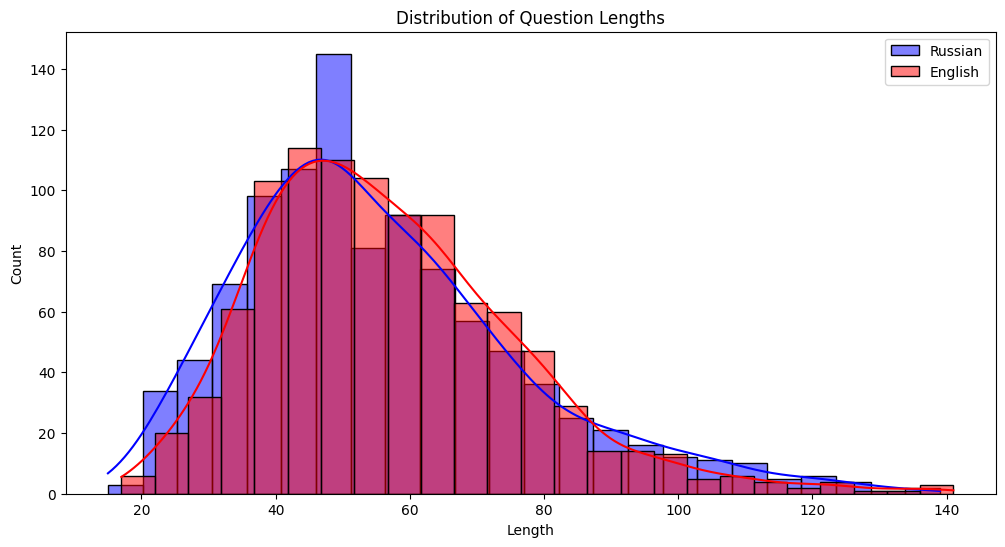

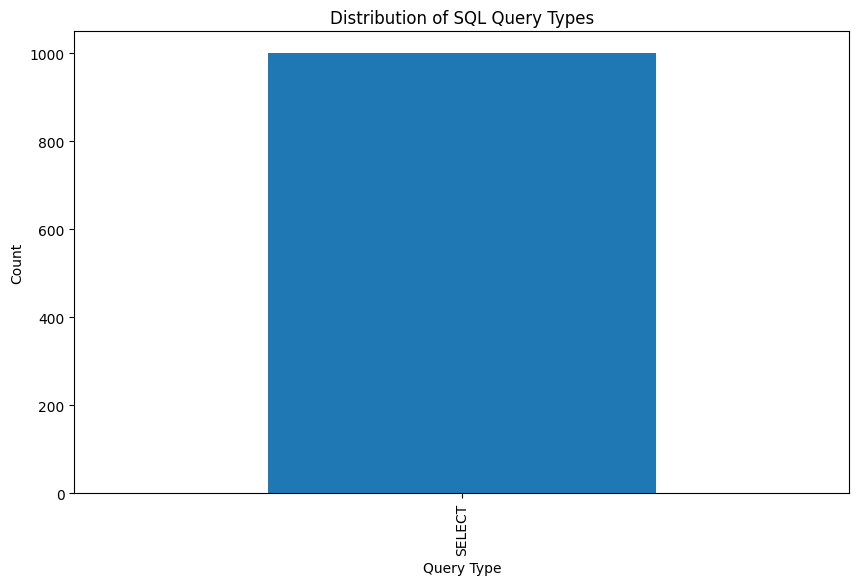

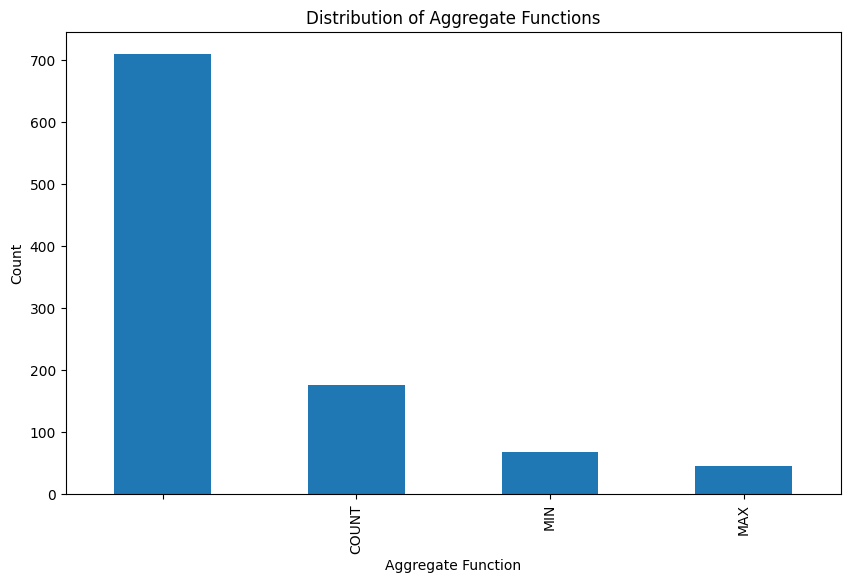

             sel         agg  question_ru_length  question_en_length
count  1000.0000  1000.00000          1000.00000         1000.000000
mean      2.9900     0.71000            55.68700           56.753000
std       2.2228     1.18292            21.28676           19.401609
min       0.0000     0.00000            15.00000           17.000000
25%       1.0000     0.00000            41.00000           43.000000
50%       3.0000     0.00000            51.50000           54.000000
75%       4.0000     1.00000            67.00000           68.000000
max      10.0000     3.00000           139.00000          141.000000


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

df['question_ru_length'] = df['question_ru'].str.len()
df['question_en_length'] = df['question_en'].str.len()

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='question_ru_length', kde=True, color='blue', label='Russian')
sns.histplot(data=df, x='question_en_length', kde=True, color='red', label='English')
plt.title('Distribution of Question Lengths')
plt.xlabel('Length')
plt.legend()
plt.show()

df['query_type'] = df['sql_query'].apply(lambda x: x.split()[0])
plt.figure(figsize=(10, 6))
df['query_type'].value_counts().plot(kind='bar')
plt.title('Distribution of SQL Query Types')
plt.xlabel('Query Type')
plt.ylabel('Count')
plt.show()

agg_funcs = ["", "MAX", "MIN", "COUNT", "SUM", "AVG"]
df['agg_func'] = df['agg'].map(lambda x: agg_funcs[x] if x < len(agg_funcs) else "UNKNOWN")
plt.figure(figsize=(10, 6))
df['agg_func'].value_counts().plot(kind='bar')
plt.title('Distribution of Aggregate Functions')
plt.xlabel('Aggregate Function')
plt.ylabel('Count')
plt.show()

print(df.describe())

*7. Text Preprocessing*
The preprocess_text function performs text cleaning and tokenization for Russian text, removing stop words. This step is necessary for preparing the text for vectorization.

In [35]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('russian'))
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

df['question_ru_processed'] = df['question_ru'].apply(preprocess_text)

print(df[['question_ru', 'question_ru_processed']].head())

                                         question_ru  \
0   Скажи мне, какие примечания для Южной Австралии?   
1  Какая сейчас серия, новая серия началась в июн...   
2                      Каков формат Южной Австралии?   
3  Назовите цвет фона австралийской столичной тер...   
4  сколько раз топливная тяга является сжиженным ...   

                               question_ru_processed  
0             скажи какие примечания южной австралии  
1          серия новая серия началась июне 2011 года  
2                       каков формат южной австралии  
3  назовите цвет фона австралийской столичной тер...  
4  сколько топливная тяга является сжиженным прир...  


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/a.getashvili/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/a.getashvili/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


*8. Splitting Data*
Data is split into training and testing sets using train_test_split, allowing the model to be trained on one part of the data and evaluated on another.

In [36]:
from sklearn.model_selection import train_test_split

X = df['question_ru_processed']
y = df['sql_query']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 800
Test set size: 200


*9. Vectorizing Text*
Texts are transformed into numerical vectors using TfidfVectorizer, which is required for machine learning model training.

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

*10. Training Logistic Regression*
A logistic regression model is trained on the vectorized data. This model is used for an initial assessment of classification performance.

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression(multi_class='ovr', max_iter=1000)
model.fit(X_train_vectorized, y_train)

y_pred = model.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))

/Users/a.getashvili/Documents/LLM_Digital_Person_AI/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


                                                                                                              precision    recall  f1-score   support

      SELECT COUNT(column1) FROM table_name WHERE column10 = 'BGS' AND column8 = 'ACGS' AND column2 = 'ACGS'       0.00      0.00      0.00       1.0
                                   SELECT COUNT(column1) FROM table_name WHERE column2 = '"Conference Call"'       0.00      0.00      0.00       1.0
                         SELECT COUNT(column1) FROM table_name WHERE column2 = 'Bosch Spark Plug Grand Prix'       0.00      0.00      0.00       1.0
                                   SELECT COUNT(column1) FROM table_name WHERE column2 = 'Natalia Raskokoha'       0.00      0.00      0.00       1.0
                                               SELECT COUNT(column1) FROM table_name WHERE column3 = '17.72'       0.00      0.00      0.00       1.0
                                            SELECT COUNT(column1) FROM table_name WHERE column5 = '

/Users/a.getashvili/Documents/LLM_Digital_Person_AI/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/a.getashvili/Documents/LLM_Digital_Person_AI/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/a.getashvili/Documents/LLM_Digital_Person_AI/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

*11. Training Data Information*
Information about the classes in the training set is displayed to ensure that the data is balanced.

In [35]:
print(y_train.nunique())
print(y_train.value_counts())

782
sql_query
SELECT MIN(column2) FROM table_name                                   4
SELECT MAX(column2) FROM table_name                                   3
SELECT column8 FROM table_name WHERE column3 = '2R'                   2
SELECT column3 FROM table_name WHERE column2 = 'French Grand Prix'    2
SELECT column7 FROM table_name WHERE column5 = 'Jim Pugh'             2
                                                                     ..
SELECT column3 FROM table_name WHERE column1 = '2053'                 1
SELECT column1 FROM table_name WHERE column5 = 'D5244 T7'             1
SELECT column5 FROM table_name WHERE column2 = 'Zeltweg Airfield'     1
SELECT column6 FROM table_name WHERE column4 = 'Mike Hawthorn'        1
SELECT column5 FROM table_name WHERE column1 = 12                     1
Name: count, Length: 782, dtype: int64


*12. Extracting SQL Components*
The extract_components function splits SQL queries into parts, such as SELECT and WHERE. This allows for additional analysis at the component level.

In [39]:
def extract_components(sql):
    select = sql.split('FROM')[0].strip()
    where = sql.split('WHERE')[-1].strip() if 'WHERE' in sql else ''
    return select, where

df['select'], df['where'] = zip(*df['sql_query'].apply(extract_components))

*13. Training Random Forest*
A random forest model is trained on the same vectorized data as the logistic regression model. This can help improve prediction quality with a more complex model.

In [40]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_vectorized, y_train)

RandomForestClassifier(random_state=42)

*14. Classifying SQL Queries*
The categorize_sql function classifies SQL queries by type. A new column in the DataFrame is created with these categories, and the data is split again.

In [41]:
from sklearn.preprocessing import LabelEncoder

def categorize_sql(query):
    if 'SELECT' in query and 'WHERE' in query:
        return 'SELECT_WITH_WHERE'
    elif 'SELECT' in query:
        return 'SELECT_ONLY'
    else:
        return 'OTHER'

df['sql_category'] = df['sql_query'].apply(categorize_sql)

le = LabelEncoder()
y = le.fit_transform(df['sql_category'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

*15. Training Neural Network*
A neural network is created and trained using Keras. The model is trained on the vectorized data and used for more complex classification of queries.

In [42]:
from keras.src.optimizers import Adam
from keras.src.layers import Dense, Dropout
from keras import Sequential

num_classes = len(set(y))

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_vectorized.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

X_train_dense = X_train_vectorized.toarray()
X_test_dense = X_test_vectorized.toarray()

model.fit(X_train_dense, y_train, epochs=10, batch_size=32, validation_split=0.2)

num_classes = len(set(y))

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_vectorized.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

X_train_dense = X_train_vectorized.toarray()
X_test_dense = X_test_vectorized.toarray()

model.fit(X_train_dense, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


/Users/a.getashvili/Documents/LLM_Digital_Person_AI/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6705 - loss: 0.6668 - val_accuracy: 0.9937 - val_loss: 0.4993
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9633 - loss: 0.4466 - val_accuracy: 0.9937 - val_loss: 0.2070
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9733 - loss: 0.1928 - val_accuracy: 0.9937 - val_loss: 0.0621
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9615 - loss: 0.1384 - val_accuracy: 0.9937 - val_loss: 0.0441
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9718 - loss: 0.0900 - val_accuracy: 0.9937 - val_loss: 0.0439
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9674 - loss: 0.0882 - val_accuracy: 0.9937 - val_loss: 0.0444
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9718 - loss: 0.0775 - val_accuracy: 0.9937 - val_loss: 0.0429
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9551 - loss: 0.0860 - val_accuracy: 0.9937 - val_loss: 0.0412
Epo

*16. Class Distribution*
Class distribution in the training and testing sets is displayed after applying class weights. This helps understand how class imbalance might affect the model.

In [43]:
import numpy as np

train_class_counts = np.unique(y_train, return_counts=True)
test_class_counts = np.unique(y_test, return_counts=True)

print("Training class distribution:")
for cls, count in zip(train_class_counts[0], train_class_counts[1]):
    print(f"Class {cls}: {count} samples")

print("\nTesting class distribution:")
for cls, count in zip(test_class_counts[0], test_class_counts[1]):
    print(f"Class {cls}: {count} samples")


Training class distribution:
Class 0: 21 samples
Class 1: 779 samples

Testing class distribution:
Class 0: 4 samples
Class 1: 196 samples


*17. Model Evaluation*
The model is evaluated on the test set. Confusion matrix and classification report are printed to assess its performance and identify any weaknesses.

In [44]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

model.fit(X_train_dense, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weight_dict)

predictions = model.predict(X_test_dense)
predicted_categories = le.inverse_transform(predictions.argmax(axis=1))

print(confusion_matrix(le.inverse_transform(y_test), predicted_categories))
print(classification_report(le.inverse_transform(y_test), predicted_categories))

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9730 - loss: 0.6071 - val_accuracy: 0.9937 - val_loss: 0.0769
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9832 - loss: 0.3960 - val_accuracy: 0.9937 - val_loss: 0.1145
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9994 - loss: 0.3789 - val_accuracy: 0.9875 - val_loss: 0.1044
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.2537 - val_accuracy: 0.9812 - val_loss: 0.0985
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.1805 - val_accuracy: 0.9688 - val_loss: 0.1103
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.1512 - val_accuracy: 0.9500 - val_loss: 0.1383
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0694 - val_accuracy: 0.9438 - val_loss: 0.1486
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0599 - val_accuracy: 0.9375 - val_loss: